# Trabajo semanal 8 - Laboratorio de filtros digitales.
## Parte 1 - Diseño de filtros
Se necesita eliminar las interferencias de una señal electrocardiográfica (ECG) que fue registrada a una frecuencia de muestreo de 1 kHz. Para ello se propone la siguiente plantilla de diseño:

### Diseño IRR:
Para el diseño del filtro IRR se utilizo la herramienta pyfda la cual permitio el desarroyo del filtro objetivo sin mucha dificultad. Dentro del abanico de tipos de filtros se utilizo un filtro IRR tipo eliptico debido a ser el filtro IRR con respuesta mas imediate, santisfaciendo el ejercicio con un filtro de 5°.

In [1]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla, analyze_sys

fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2
# Plantilla

# filter design
ripple = 0 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


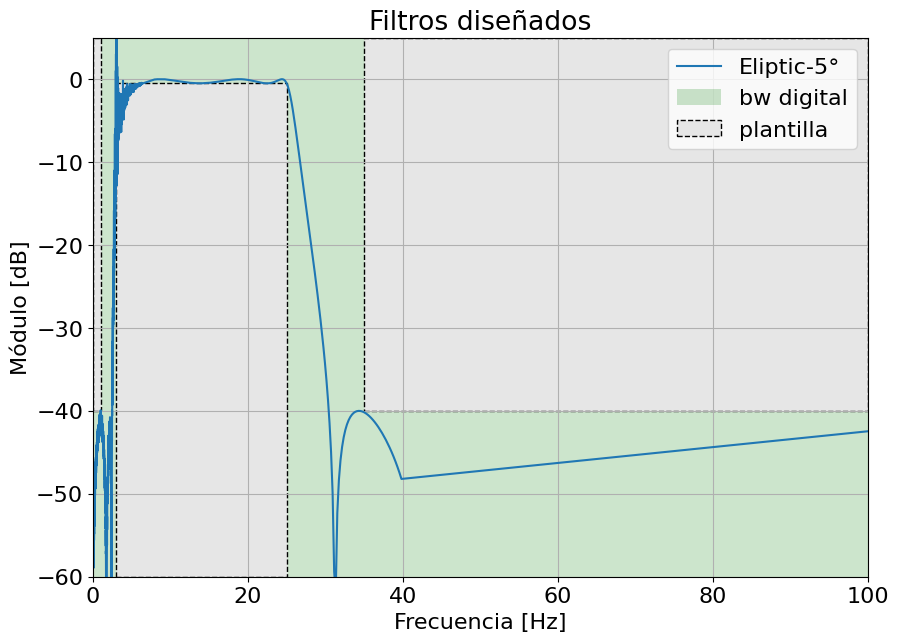

In [2]:
ba_pyfda = np.load('ba.npy')

# renormalizo el eje de frecuencia
# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 2500), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 1000, endpoint=True) ) / nyq_frec * np.pi

_, mag = sig.freqz(ba_pyfda[0], ba_pyfda[1], w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

#plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win '.format(num_win.shape[0]))

plt.figure(2)
plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()
#def plot_plantilla(filter_type = 'lowpass', fpass = 0.25, ripple = 0.5, fstop = 0.6, attenuation = 40, fs = 2 ):
ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz
fs = 10**3

plt.plot(w, 20 * np.log10(abs(mag)), label='Eliptic-5°')
plot_plantilla(filter_type = 'bandpass', fpass = [wp1,wp2], ripple = 0.5, fstop = [ws1,ws2], attenuation = 40, fs = fs )

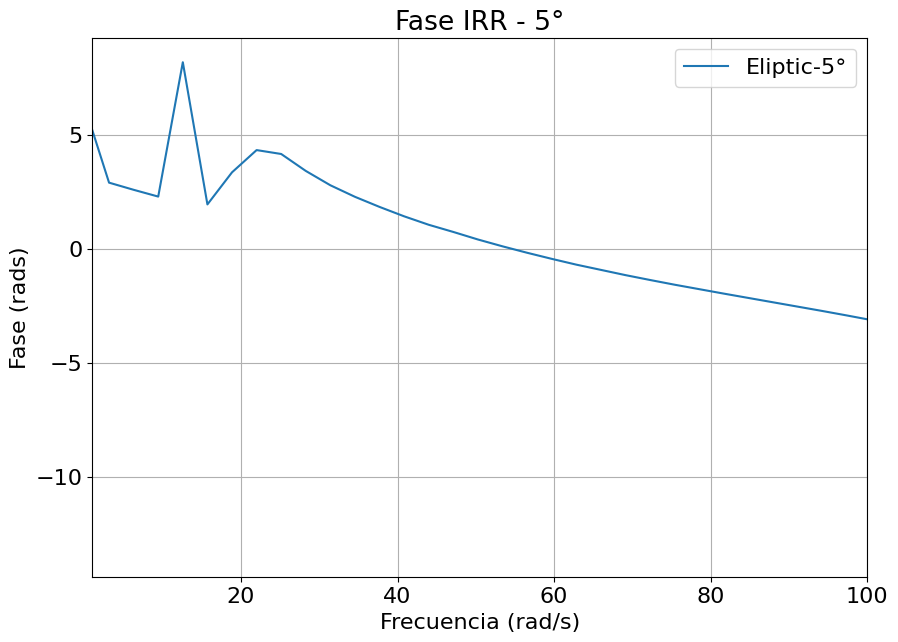

In [3]:
tf = sig.dlti(ba_pyfda[0], ba_pyfda[1], dt=1/fs)  # dt es el período de muestreo

# Calcula las respuestas en frecuencia (Bode plot) para el sistema discreto
w_, mag, phase = sig.dlti.bode(tf, 10**3)

plt.figure(1)
plt.plot(w_, phase*2*np.pi/180, label='Eliptic-5°')
plt.grid(True)
plt.title('Fase IRR - 5°')
plt.xlabel('Frecuencia (rad/s)')
plt.ylabel('Fase (rads)')
plt.legend()
plt.xlim(1,100)
# Mostrar el gráfico
plt.show()

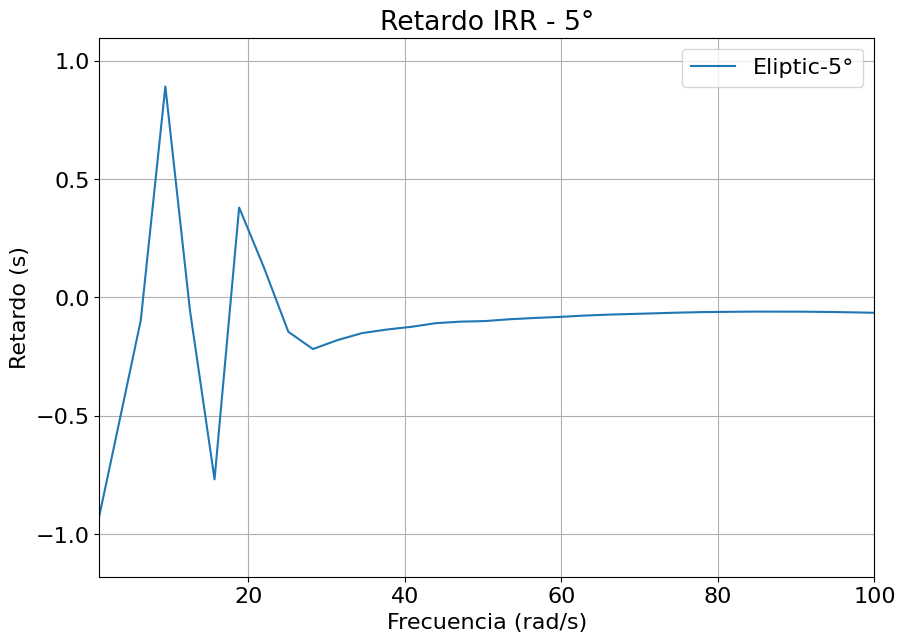

In [4]:
retar = np.gradient(phase*2*np.pi/180,w_)
plt.figure(2)
plt.plot(w_, retar, label='Eliptic-5°')
plt.grid(True)
plt.title('Retardo IRR - 5°')
plt.xlabel('Frecuencia (rad/s)')
plt.ylabel('Retardo (s)')
plt.legend()
plt.xlim(1,100)
# Mostrar el gráfico
plt.show()

Text(0, 0.5, 'Ambplitud')

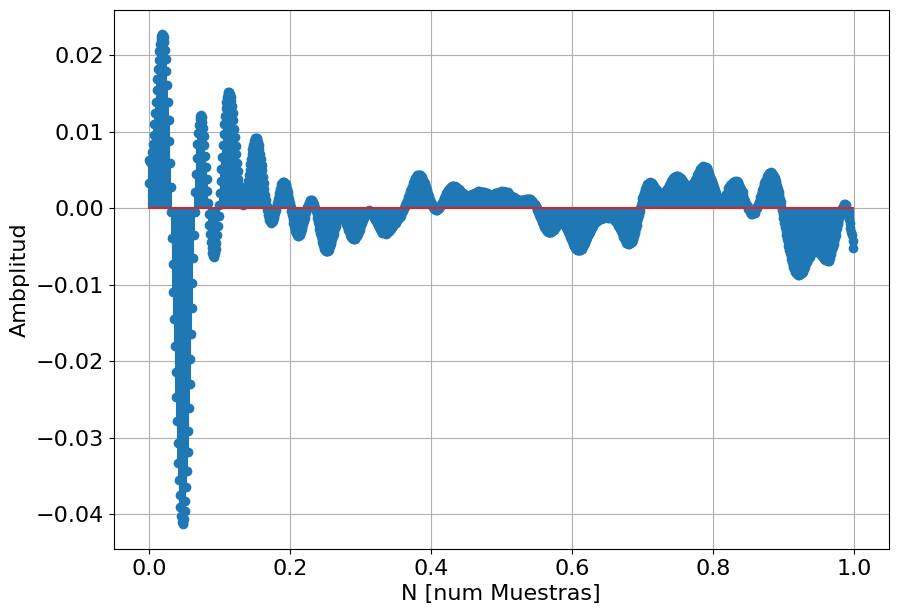

In [5]:
t, y = sig.dimpulse(tf, n=fs)
plt.stem(t, np.squeeze(y))
plt.grid()
plt.xlabel('N [num Muestras]')
plt.ylabel('Ambplitud')


### Diseño FIR:
Para el diseño de filtro FIR se utilizo la funcion de alto nivel $firwin2$ la cual nos permite seleccionar la ganancia objetivo de un filtro para difrentes frecuencias. Otra peculiaridad de esta funcion es la opcion de variar el filtro ventado utilizado para iterar y comprarbar cual es el filtro que mejor se adapta.

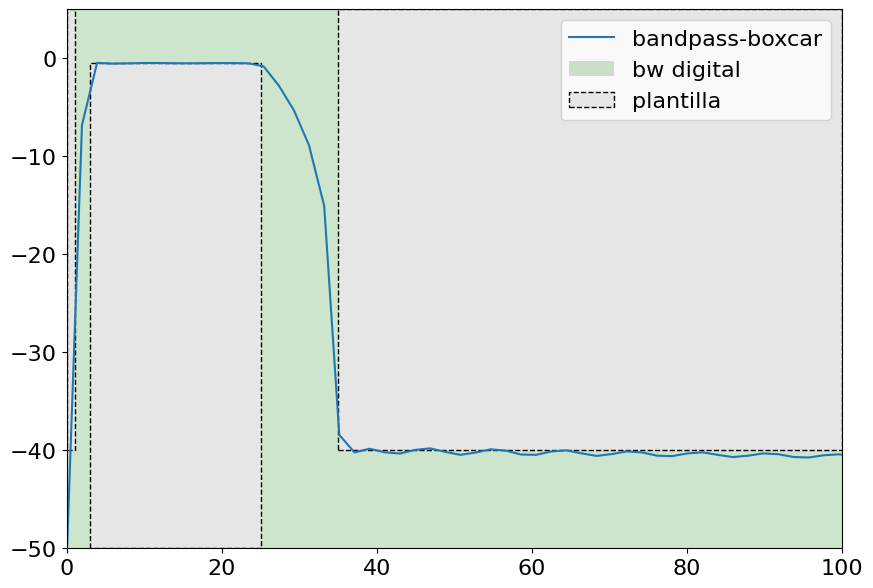

In [70]:
from scipy import signal as sig
import matplotlib.pyplot as plt
import numpy as np

from pytc2.sistemas_lineales import plot_plantilla, group_delay

cant_coef = 2500
fs = 1000
antisymmetric = False

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

if(cant_coef%2 == 0 ):
    cant_coef += 1


#####################
## tipos de filtro ##
#####################

#filter_type = 'arbitrary'
# filter_type = 'lowpass'
# filter_type = 'highpass'
filter_type = 'bandpass'
# filter_type = 'bandstop'


# plantilla
ripple = 0.5 # dB
attenuation = 40 # dB

fs1 = 1/fs # 
fp1 = 3/fs # Hz
fp2 = 25/fs # 
fs2 = 35/fs # Hz

fstop = [fs1,fs2] # 
fpass = [fp1,fp2] # Hz

# pasa banda
frecs = [0.0,          fs1,          fp1,      fp2,     fs2,         1.0]
gains = [-np.inf, -attenuation, -ripple, -ripple, -attenuation, -np.inf]
    
gains = 10**(np.array(gains)/20)
    
# fs = 1.0/np.pi
#fs = 2.0

# algunas ventanas para evaluar
win_name = 'boxcar'
#win_name = 'hamming'
#win_name = 'blackmanharris'
#win_name = 'flattop'


# FIR design
num_fir = sig.firwin2(cant_coef, frecs, gains , window=win_name, antisymmetric=antisymmetric  )
den_fir = 1.0

digital_filter = sig.TransferFunction( num_fir, den_fir, dt=1/fs)

wrad, hh = sig.freqz(num_fir, den_fir)
ww = wrad / np.pi*1000


plt.figure(3)

plt.plot(ww, 20 * np.log10(abs(hh)), label=filter_type+ '-' + win_name)

plt.xlim(0,100)
plt.ylim(-50, 5)
plot_plantilla(filter_type = 'bandpass', fpass = [wp1,wp2], ripple = 0.5, fstop = [ws1,ws2], attenuation = 40, fs = fs )




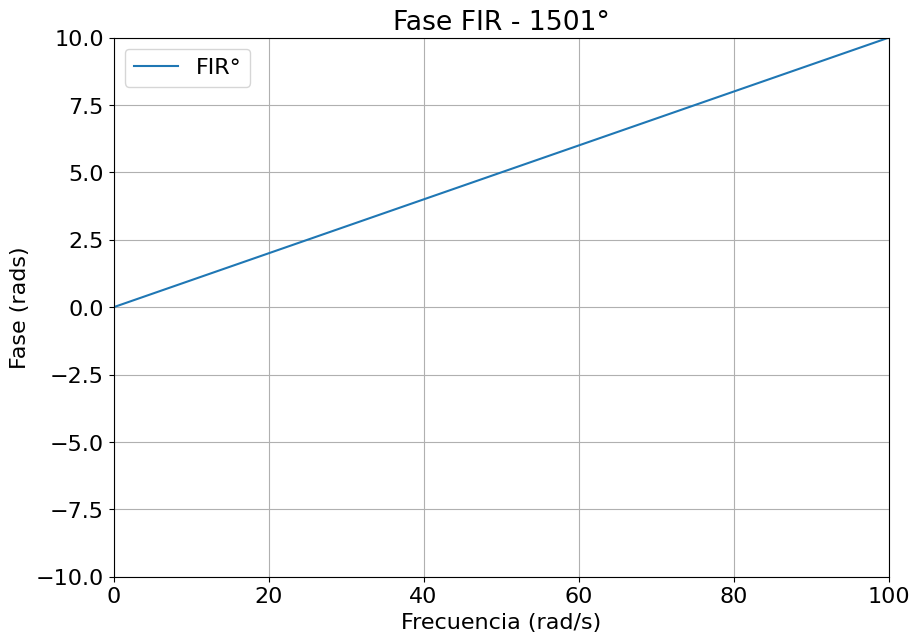

In [71]:
w_, mag, phase = digital_filter.bode()

plt.figure(1)
plt.plot(w_, phase*2*np.pi/180, label='FIR°')
plt.grid(True)
plt.title('Fase FIR - 1501°')
plt.xlabel('Frecuencia (rad/s)')
plt.ylabel('Fase (rads)')
plt.legend()
plt.xlim(0,100)
plt.ylim(-10,10)
# Mostrar el gráfico
plt.show()

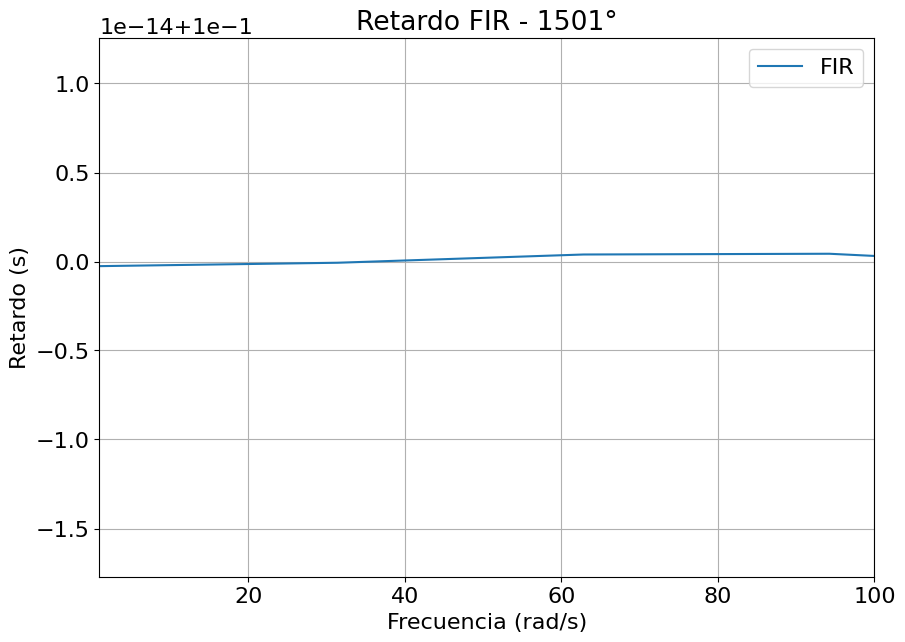

In [72]:
retar = np.gradient(phase*2*np.pi/180,w_)
plt.figure(2)
plt.plot(w_, retar, label='FIR')
plt.grid(True)
plt.title('Retardo FIR - 1501°')
plt.xlabel('Frecuencia (rad/s)')
plt.ylabel('Retardo (s)')
plt.legend()
plt.xlim(1,100)
# Mostrar el gráfico
plt.show()

## Retardo:

Text(0, 0.5, 'Ambplitud')

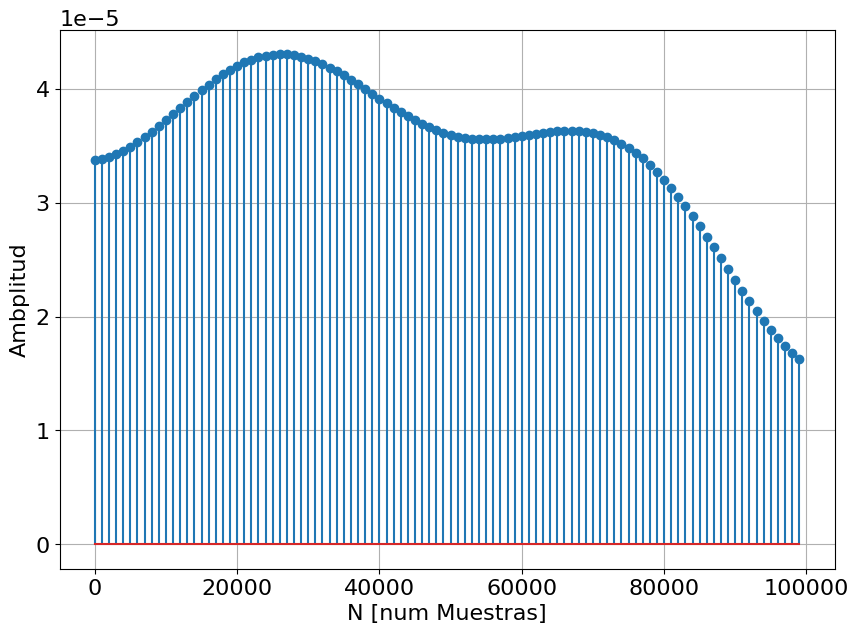

In [73]:
den_fir = np.zeros(len(num_fir)) ## Python marcaba un problema en el caso la respuesta al impulzo 
den_fir[0] = 1
system = (num_fir, den_fir,fs)
t, y = sig.dimpulse(system)

plt.stem(t, np.squeeze(y))
plt.grid()
plt.xlabel('N [num Muestras]')
plt.ylabel('Ambplitud')

# Parte 2:
https://nbviewer.org/github/marianux/jupytest/blob/master/Laboratorio%20de%20filtrado%20digital.ipynb

### Los siguientes graficos muestran las respuesta del filtro Fir diseñado tras filtrar un electrocardiograma

In [74]:
# IIR
# ECG_f_butt = sig.sosfilt(bp_sos_butter, ecg_one_lead)

# FIR
ECG_f_fir = sig.lfilter(num_fir, den_fir, ecg_one_lead)

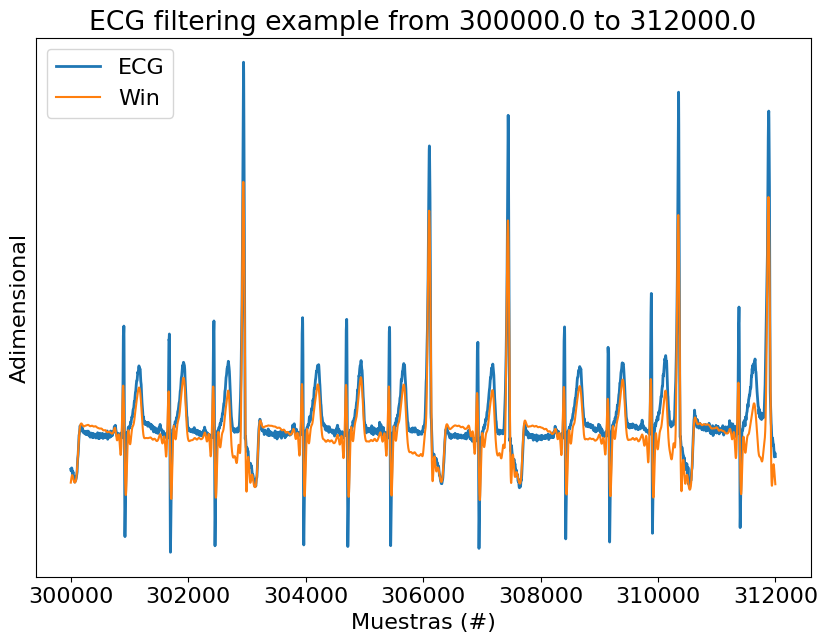

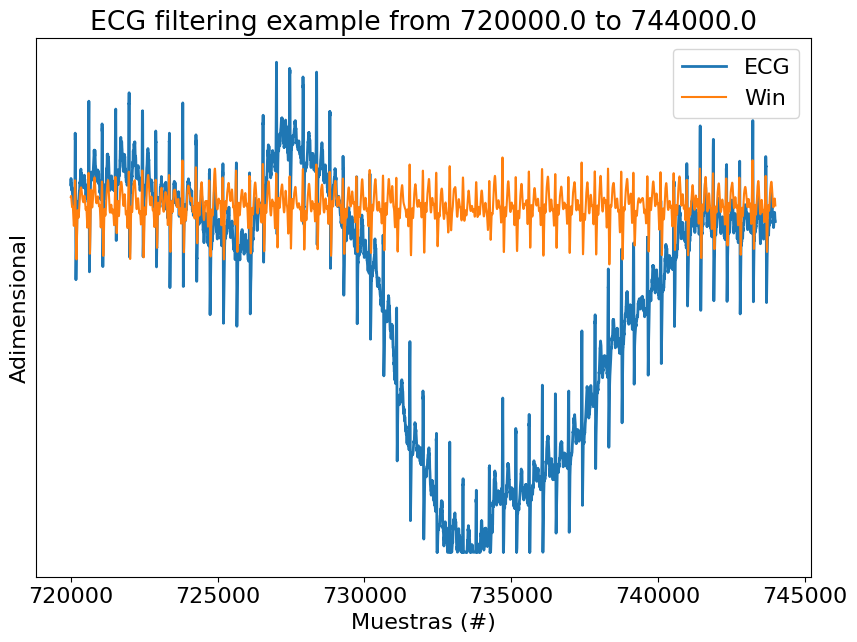

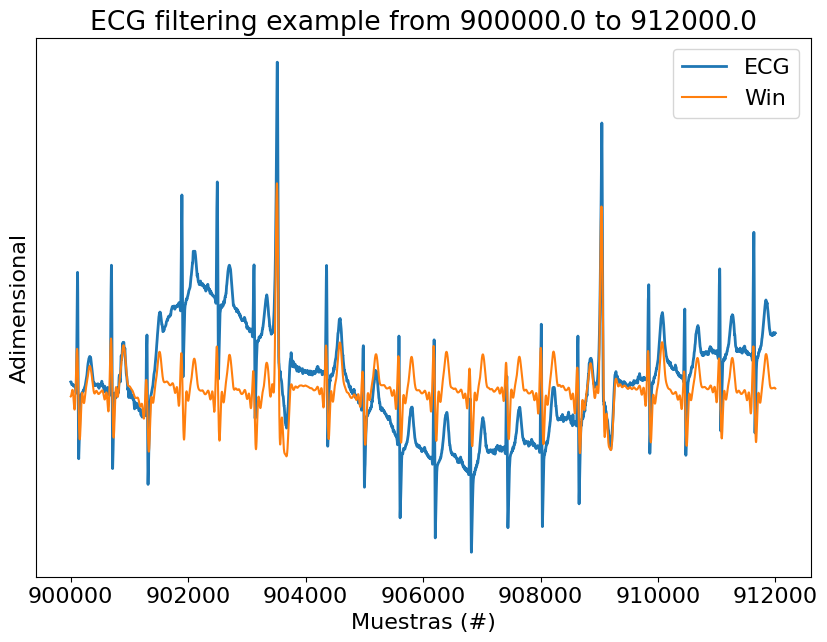

In [110]:


# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 1250


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_fir[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

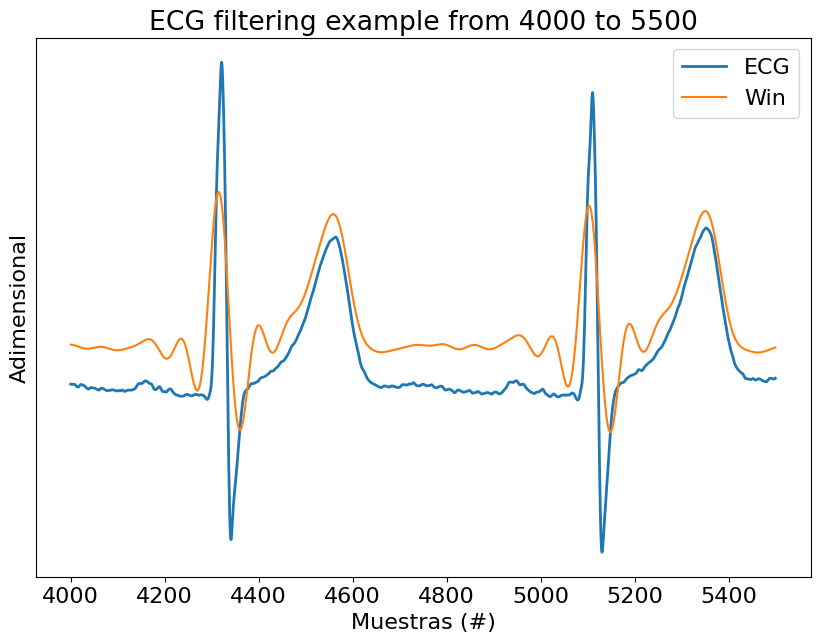

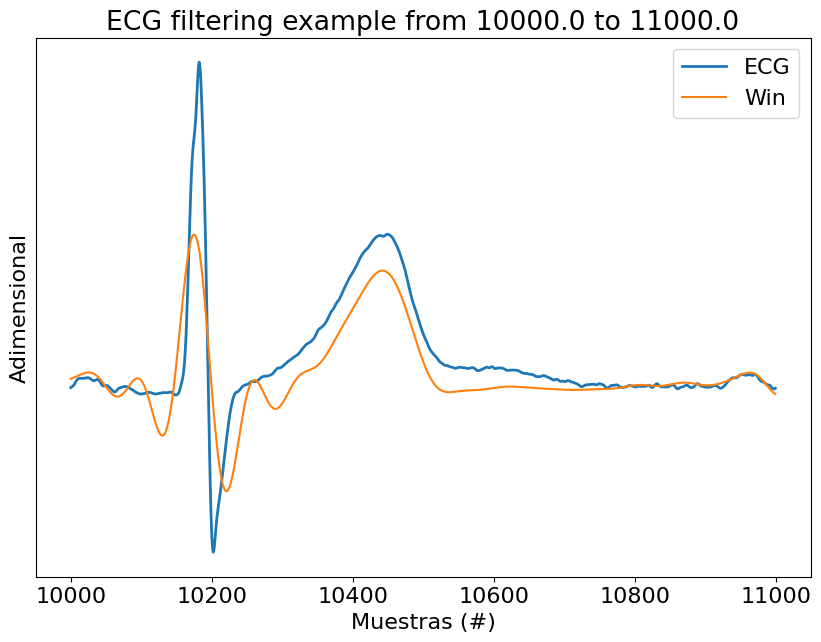

In [111]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_fir[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Como se pueden observar en estos graficos de comparatoria el filtro FIR armado no esta en sicronismo con la señal original eso se debe a que el filtro diseñado posee una cierda demora respecto a la señal original. Otra observacion es tras aplicar el filtro es la aparicion de nuevas perturbaciones tras la subida del primer riple. En este caso se puede observar una pequeñal montaña que surgio con el filtro.

# IIR:

In [83]:
from scipy import signal
# IIR
ECG_f_iir = sig.sosfilt(signal.tf2sos(ba_pyfda[0], ba_pyfda[1]), ecg_one_lead)

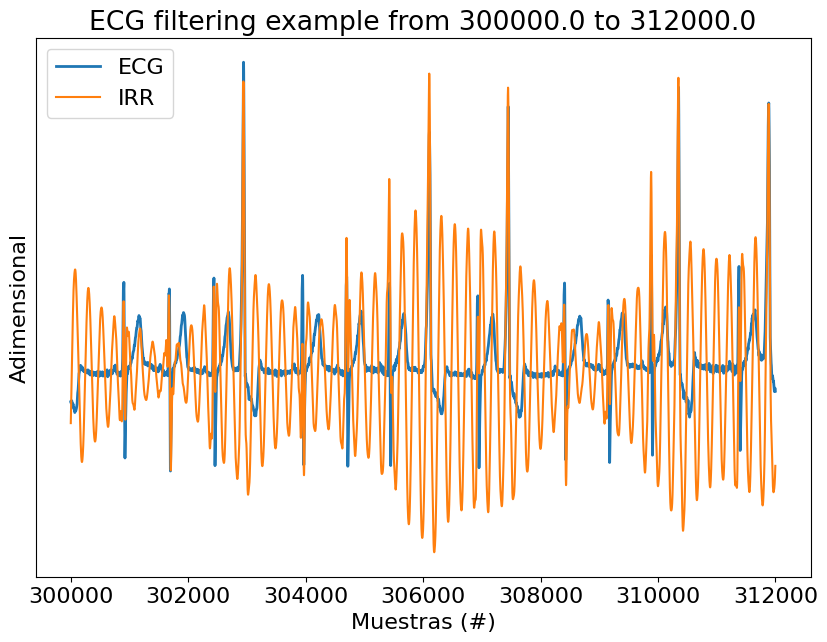

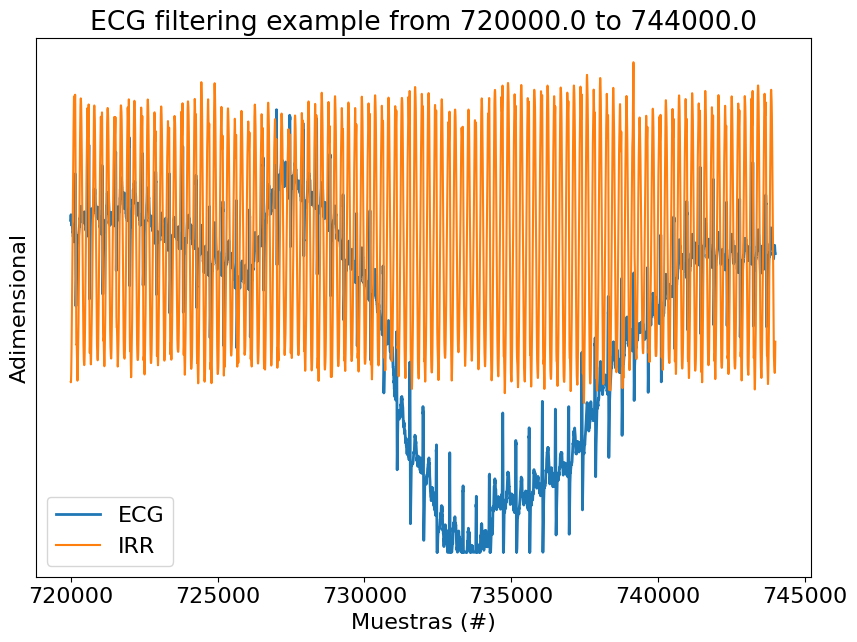

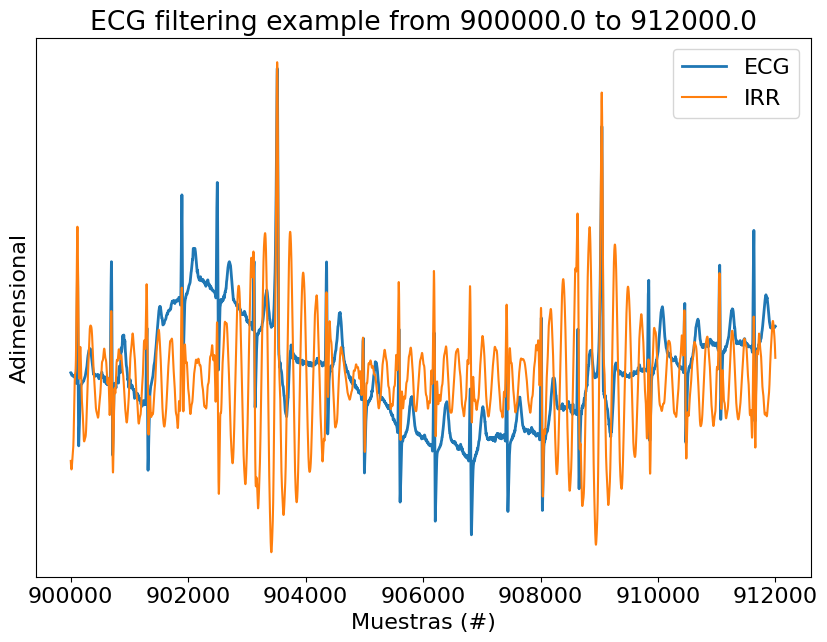

In [120]:
# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 750


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_iir[zoom_region], label='IRR')
    #plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

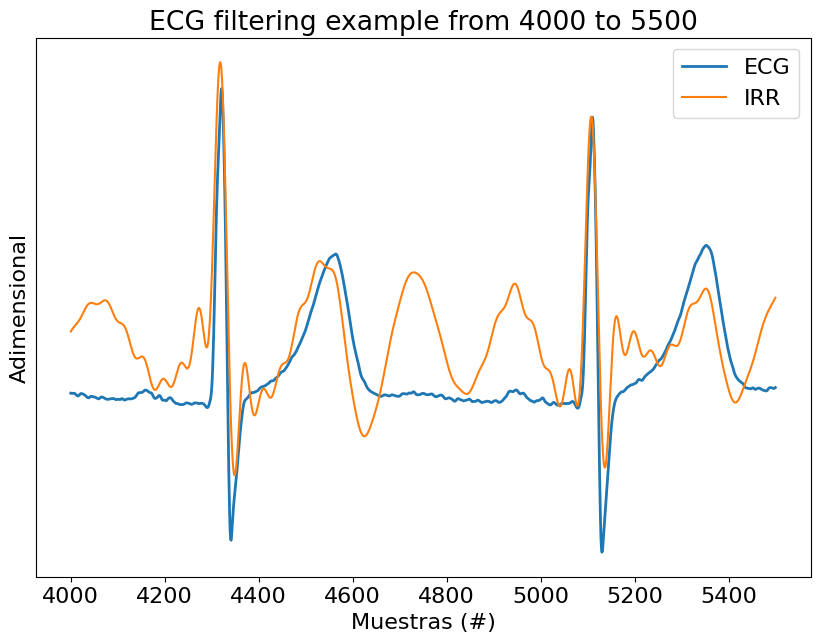

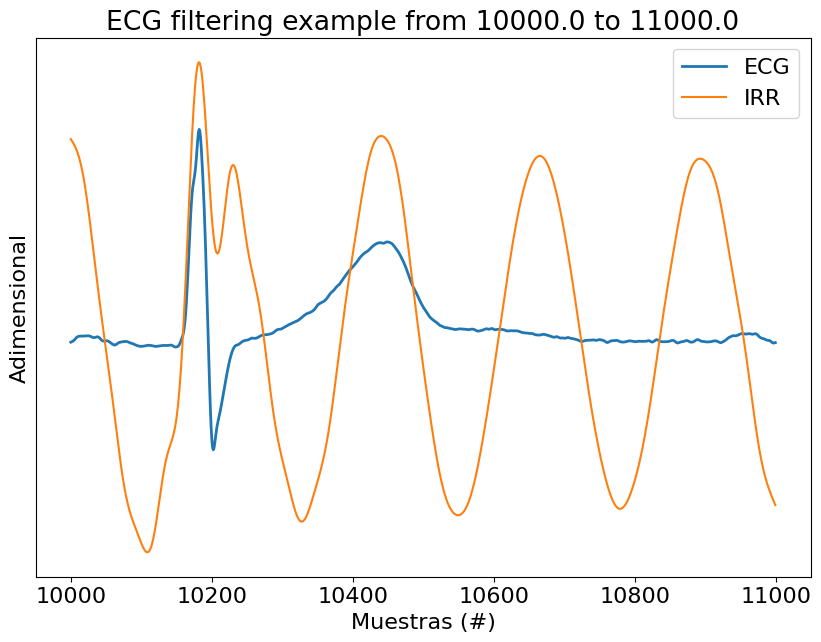

In [121]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_iir[zoom_region], label='IRR')
    #plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

A diferencia del filtro FIR obtenido el filtro IIR diseñado con pyfda no puede mantener correctamente la informacion de la señal ingresada haciendo que la misma se pierda.

# Filtrado Bidirreccional para correccion de filtrado:
Un metodo para reducir la distorcion de la señal es con el uso de un filtrado bidireccional, esto lo podremos hacer con la funcion scipy.signal.filtfilt. de scipy.

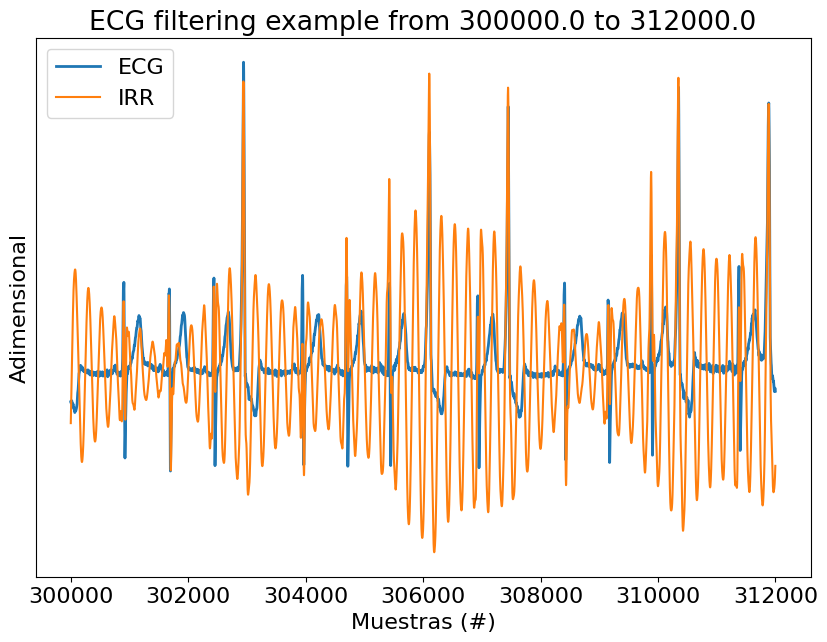

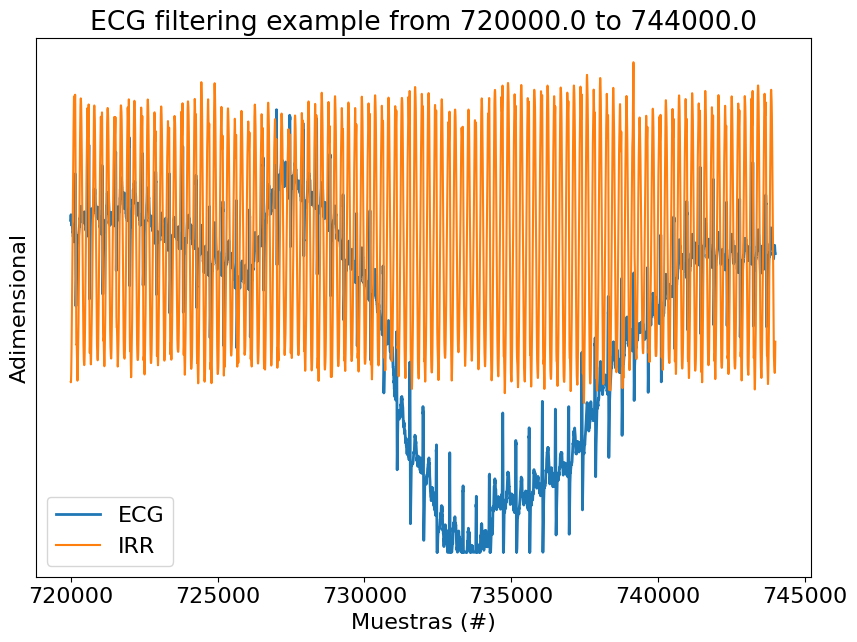

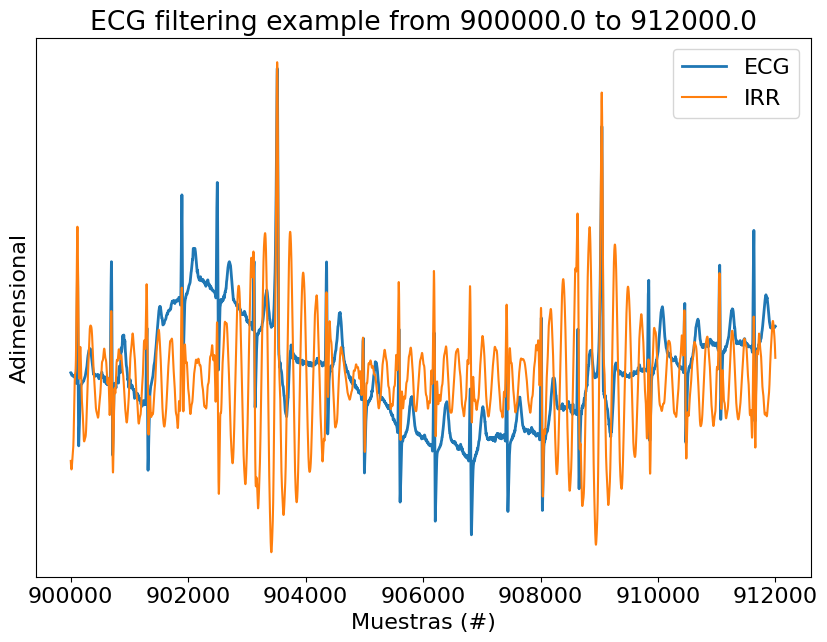

In [118]:
# Procedemos al filtrado
ECG_f_iir = sig.sosfiltfilt(signal.tf2sos(ba_pyfda[0], ba_pyfda[1]), ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_iir[zoom_region], label='IRR')
    #plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

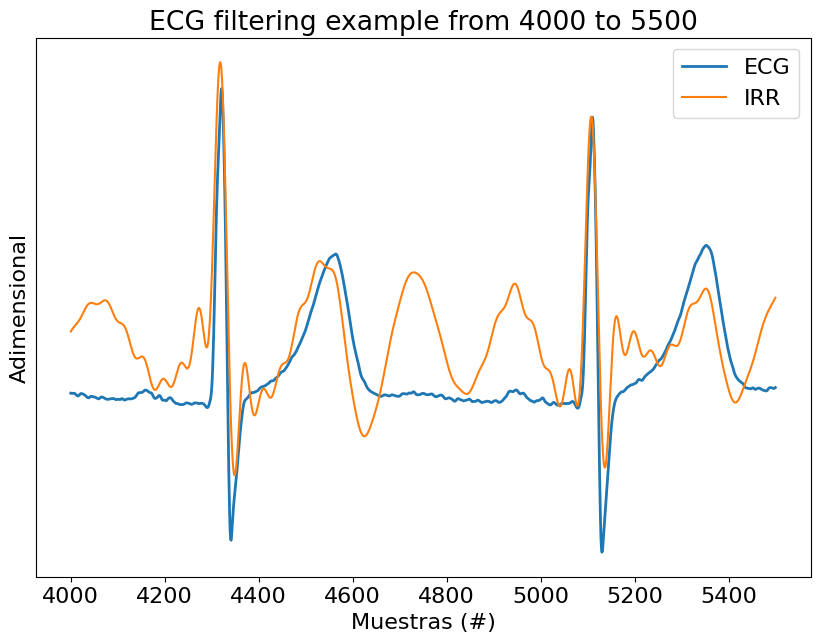

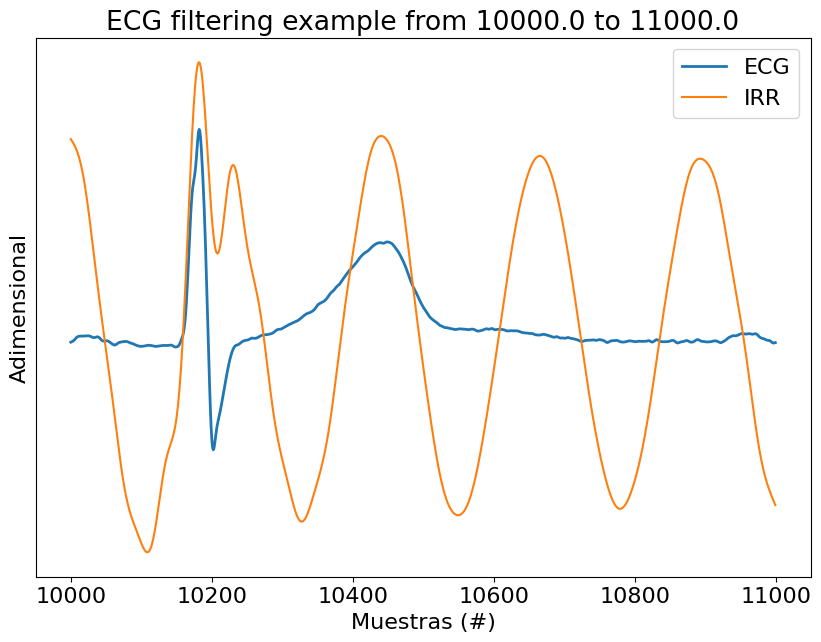

In [119]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_iir[zoom_region], label='IRR')
    #plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Como se puede obserbar hubo una gran mejora entre el filtro arreglado el filtrado bidireccional con el filtrado simple pero devido al filtro eliptico utilizado la señal no se pudo recuperar completamente.

# Preguntas:

$¿Qué pudo haber causado que los filtros no hayan sido eficientes para eliminar las interferencias?$  
  
Se logro un buen filtrado para el filtro FIR mientras que el filtro IIR no pudo lograrlo con la misma eficacia. Desde mi punto de vista, la razón detrás de la incapacidad del filtro IIR para producir una señal filtrada con baja distorsion se debe a la elección del tipo de filtro. En este caso, se empleó un filtro elíptico, conocido por su rápida transición, pero que a costa de ello exhibe un comportamiento sinusoide en todo su rango, lo que conlleva a una considerable distorcion la cual no se pudo corregir con el filtrado bilineal. Si se hubiera optado por un filtro Butterworth IIR, posiblemente se habría logrado una mejor reconstrucción de la señal, ya que este tipo de filtro presenta menos variación de amplitud en comparación con el filtro elíptico.

$¿Qué pudo haber causado que los filtros no hayan sido inocuos respecto a las señales NO contaminadas?$  

El filtro filtra por señales sin considerar que las mismas poseen o no informacion, debido a esto el filtro contamina la informacion para poder atenuar el ruido.